In [6]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score, 
    precision_recall_curve, confusion_matrix, roc_auc_score, 
    matthews_corrcoef, roc_curve
)
import matplotlib.pyplot as plt

In [7]:
def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

def scores(y_test, y_pred, th=0.5):           
    y_predlabel = [(0. if item < th else 1.) for item in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_predlabel).flatten()
    SPE = tn / (tn + fp)
    MCC = matthews_corrcoef(y_test, y_predlabel)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    sen, spe, pre, f1, mcc, acc, auc, tn, fp, fn, tp = np.array([
        recall_score(y_test, y_predlabel), SPE, precision_score(y_test, y_predlabel), 
        f1_score(y_test, y_predlabel), MCC, accuracy_score(y_test, y_predlabel), 
        roc_auc_score(y_test, y_pred), tn, fp, fn, tp
    ])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    aupr = get_aupr(precision, recall)
    return [aupr, auc, f1, acc, sen, spe, pre, fpr, tpr, precision, recall]


In [8]:
def construct_feature_matrices(lociembeddings_path, rbpembeddings_path, mode='train'):
    """
    This function constructs two corresponding feature matrices ready for machine learning, 
    starting from the ESM-2 embeddings of RBPs and loci proteins.

    INPUTS:
    - path: general or test path depending on the mode
    - suffix: general or test suffix depending on the mode
    - lociembeddings path to the loci embeddings csv file
    - rbpembeddings path to the rbp embeddings csv file
    - mode: 'train' or 'test', test mode doesn't use an IM (default='train')
    OUTPUT: features_esm2, labels, groups_loci, groups_phage
    """
    RBP_embeddings = pd.read_csv(rbpembeddings_path)
    loci_embeddings = pd.read_csv(lociembeddings_path)
    if mode == 'train':
        interactions = pd.read_csv("./phage_host_interactions"+'.csv', index_col=0)

    # construct multi-RBP representations
    multi_embeddings = []
    names = []
    for phage_id in list(set(RBP_embeddings['phage_ID'])):
        rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
        multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
        names.append(phage_id)
        multi_embeddings.append(multi_embedding)
    multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

    # construct dataframe for training
    features_lan = []
    labels = []
    groups_loci = []
    groups_phage = []

    for i, accession in enumerate(loci_embeddings['accession']):
        for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
            if mode == 'train':
                interaction = interactions.loc[accession][phage_id]
                if not math.isnan(interaction): # if the interaction is known
                    # language embeddings
                    features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))

                    # append labels and groups
                    labels.append(int(interaction))
                    groups_loci.append(i)
                    groups_phage.append(j)
            elif mode == 'test':
                # language embeddings
                features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
                
                # append groups
                groups_loci.append(i)
                groups_phage.append(j)

                
    features_lan = np.asarray(features_lan)
    print("Dimensions match?", features_lan.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))

    #np.save(general_path+'/esm2_features'+data_suffix+'.txt', features_lan)
    if mode == 'train':
        return features_lan, labels, groups_loci, groups_phage
    elif mode == 'test':
        return features_lan, groups_loci


In [9]:
general_output_path = "./esm-features"

loci_embeddings_path = "./esm-features/esm2_embeddings_loci.csv"
rbp_embeddings_path ="./esm-features/esm2_embeddings_rbp.csv"

features_esm2, labels, groups_loci, groups_phage = construct_feature_matrices(loci_embeddings_path, rbp_embeddings_path)

Dimensions match? True


In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cpus = 8
scores_lan = []
label_list = []

labels = np.asarray(labels)
features_esm2 = np.asarray(features_esm2)  # ensure it's a NumPy array

pbar = tqdm(total=kf.get_n_splits(features_esm2, labels))

for train_index, test_index in kf.split(features_esm2, labels):
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    imbalance = sum([1 for i in y_train if i == 1]) / sum([1 for i in y_train if i == 0])

    xgb = XGBClassifier(
        scale_pos_weight=1/imbalance,
        learning_rate=0.3,
        n_estimators=250,
        max_depth=7,
        n_jobs=cpus,
        eval_metric='logloss',
    )
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:, 1]

    scores_lan.append(score_xgb)
    label_list.append(y_test)
    pbar.update(1)

pbar.close()



 60%|██████    | 3/5 [01:17<00:51, 25.87s/it]

100%|██████████| 5/5 [01:40<00:00, 20.07s/it]


In [11]:
# Apply metric evaluation for each fold
results_all = []
fprs, tprs, precisions, recalls = [], [], [], []

for y_true, y_pred in zip(label_list, scores_lan):
    fold_metrics = scores(y_true, y_pred)
    results_all.append(fold_metrics[:7])
    fprs.append(fold_metrics[7])
    tprs.append(fold_metrics[8])
    precisions.append(fold_metrics[9])
    recalls.append(fold_metrics[10])


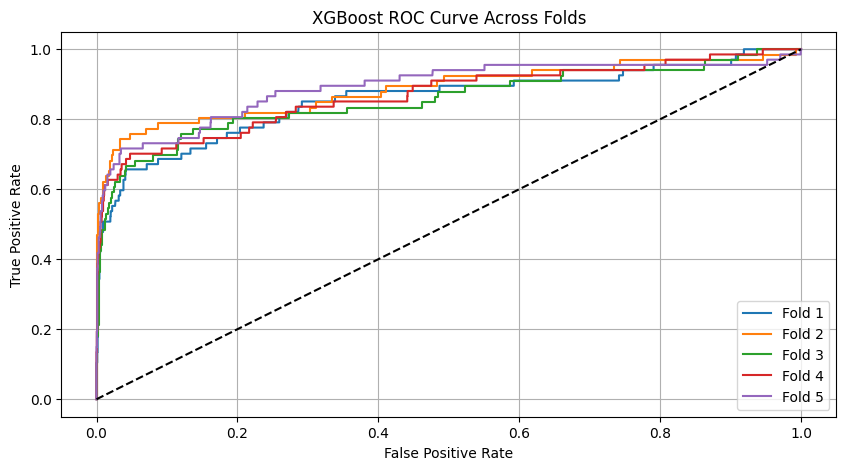

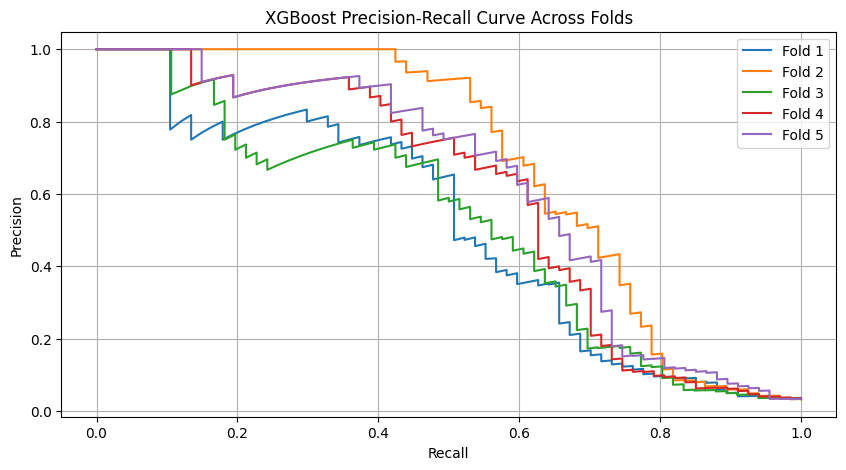

In [12]:

plt.figure(figsize=(10, 5))
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("XGBoost ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(precisions)):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.title("XGBoost Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


C:\Users\jonas\AppData\Local\Temp\ipykernel_65448\3342353646.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results_array, labels=metric_names, patch_artist=True,


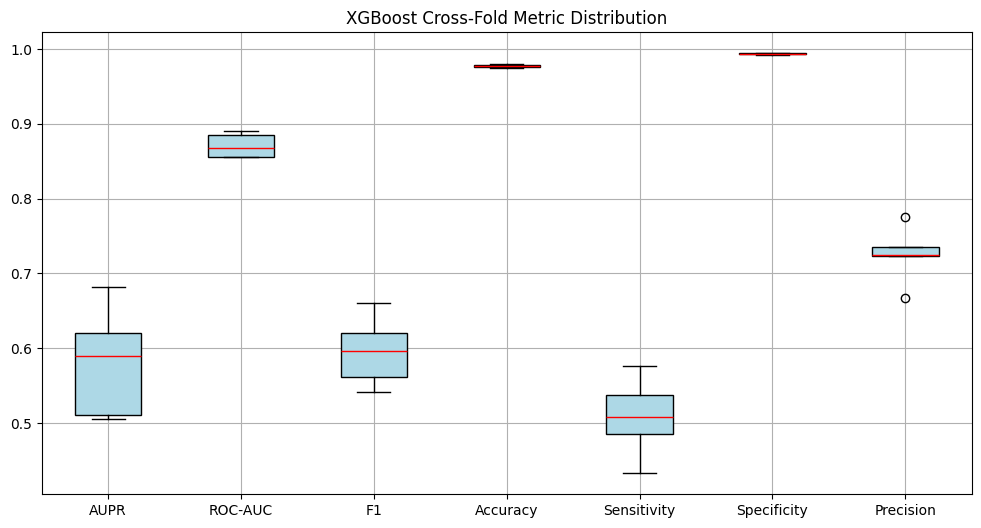

,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.505410,0.855806,0.542056,0.975524,0.432836,0.994315,0.725000
Fold 2,0.682246,0.885381,0.660870,0.980510,0.575758,0.994315,0.775510
Fold 3,0.511257,0.855219,0.561404,0.975012,0.484848,0.991731,0.666667
Fold 4,0.590091,0.867551,0.596491,0.977011,0.507463,0.993278,0.723404
Fold 5,0.619765,0.891073,0.620690,0.978011,0.537313,0.993278,0.734694


Mean Metrics:


AUPR           0.581754
ROC-AUC        0.871006
F1             0.596302
Accuracy       0.977214
Sensitivity    0.507644
Specificity    0.993384
Precision      0.725055
dtype: float64

In [13]:


metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]
results_array = np.array(results_all)

# Boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(results_array, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("XGBoost Cross-Fold Metric Distribution")
plt.grid()
plt.show()

# Table
results_df = pd.DataFrame(results_all, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]
display(results_df)

print("Mean Metrics:")
display(results_df.mean())


In [16]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cpus = 8

rf_results_all = []
rf_fprs, rf_tprs, rf_precisions, rf_recalls = [], [], [], []

param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

labels = np.asarray(labels)
features_esm2 = np.asarray(features_esm2)

pbar = tqdm(total=kf.get_n_splits(features_esm2, labels))

for train_index, test_index in kf.split(features_esm2, labels):
    X_train, X_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    rf = RandomForestClassifier(n_jobs=-1, random_state=42)

    grid_search = GridSearchCV(
        rf,
        param_grid,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

    # compute all metrics
    metrics = scores(y_test, y_pred_prob)

    rf_results_all.append(metrics[:7])  # Base metrics
    rf_fprs.append(metrics[7])
    rf_tprs.append(metrics[8])
    rf_precisions.append(metrics[9])
    rf_recalls.append(metrics[10])

    print(f"AUPR: {metrics[0]:.4f}, AUC: {metrics[1]:.4f}, "
          f"F1: {metrics[2]:.4f}, Acc: {metrics[3]:.4f}")
    
    pbar.update(1)

pbar.close()

  0%|          | 0/5 [10:50<?, ?it/s]
D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 20%|██        | 1/5 [42:50<2:51:21, 2570.34s/it]

AUPR: 0.4902, AUC: 0.8653, F1: 0.3596, Acc: 0.9715


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 40%|████      | 2/5 [1:28:01<2:12:39, 2653.28s/it]

AUPR: 0.6712, AUC: 0.8925, F1: 0.5652, Acc: 0.9800


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 60%|██████    | 3/5 [2:06:14<1:22:57, 2488.83s/it]

AUPR: 0.5435, AUC: 0.8589, F1: 0.4348, Acc: 0.9740


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 80%|████████  | 4/5 [2:42:34<39:26, 2366.78s/it]  

AUPR: 0.5311, AUC: 0.8792, F1: 0.4222, Acc: 0.9740


D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 5/5 [3:17:31<00:00, 2370.37s/it]

AUPR: 0.6203, AUC: 0.9006, F1: 0.5306, Acc: 0.9770


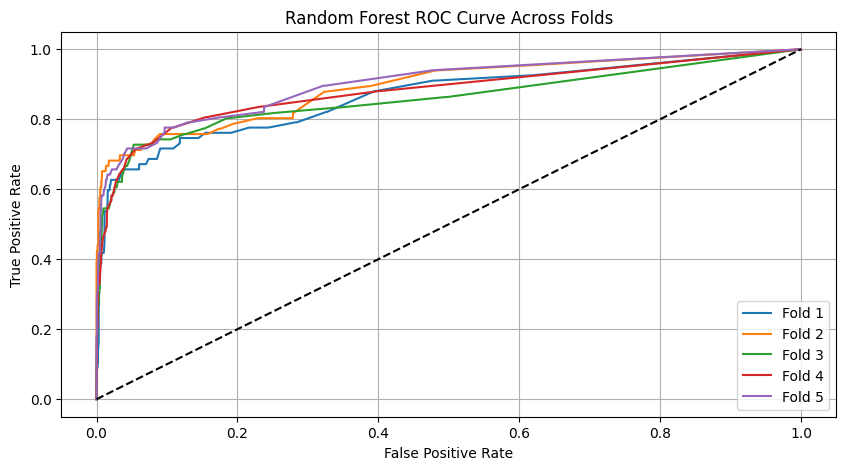

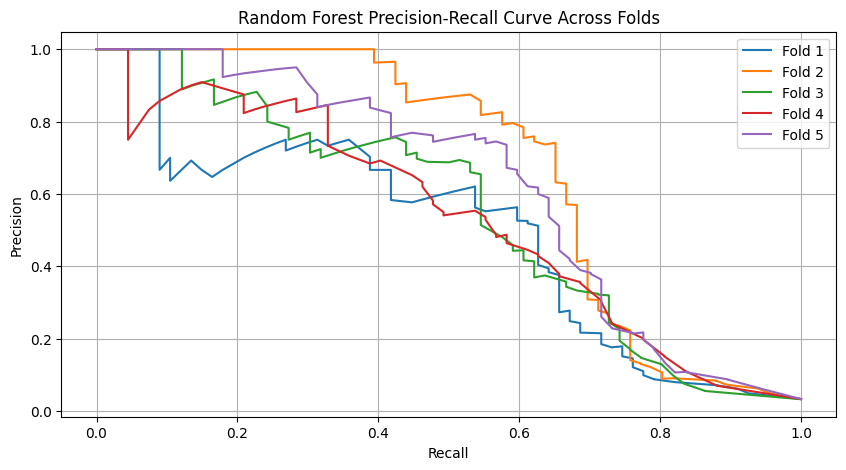

In [17]:
plt.figure(figsize=(10, 5))
for i in range(len(rf_fprs)):
    plt.plot(rf_fprs[i], rf_tprs[i], label=f'Fold {i + 1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(rf_precisions)):
    plt.plot(rf_recalls[i], rf_precisions[i], label=f'Fold {i + 1}')
plt.title("Random Forest Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


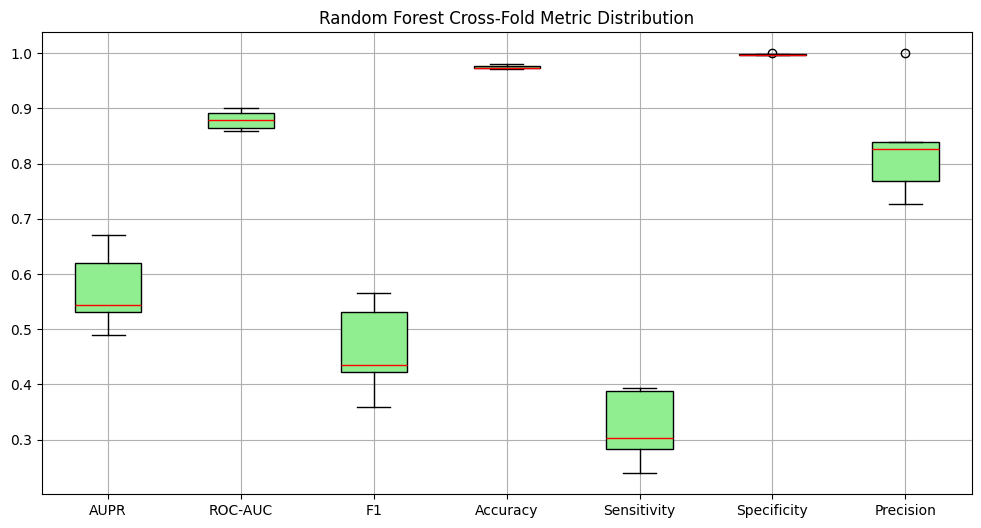

In [18]:
rf_metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]
rf_results_array = np.array(rf_results_all)

# Boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(rf_results_array, tick_labels=rf_metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Cross-Fold Metric Distribution")
plt.grid()
plt.show()


In [19]:
rf_results_df = pd.DataFrame(rf_results_all, columns=rf_metric_names)
rf_results_df.index = [f"Fold {i + 1}" for i in range(len(rf_results_all))]
display(rf_results_df)

print("Random Forest Mean Metrics:")
display(rf_results_df.mean())

,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.490172,0.865336,0.359551,0.971528,0.238806,0.996899,0.727273
Fold 2,0.671191,0.892499,0.565217,0.980010,0.393939,1.000000,1.000000
Fold 3,0.543506,0.858903,0.434783,0.974013,0.303030,0.996899,0.769231
Fold 4,0.531091,0.879239,0.422222,0.974013,0.283582,0.997932,0.826087
Fold 5,0.620347,0.900577,0.530612,0.977011,0.388060,0.997415,0.838710


Random Forest Mean Metrics:


AUPR           0.571262
ROC-AUC        0.879311
F1             0.462477
Accuracy       0.975315
Sensitivity    0.321483
Specificity    0.997829
Precision      0.832260
dtype: float64

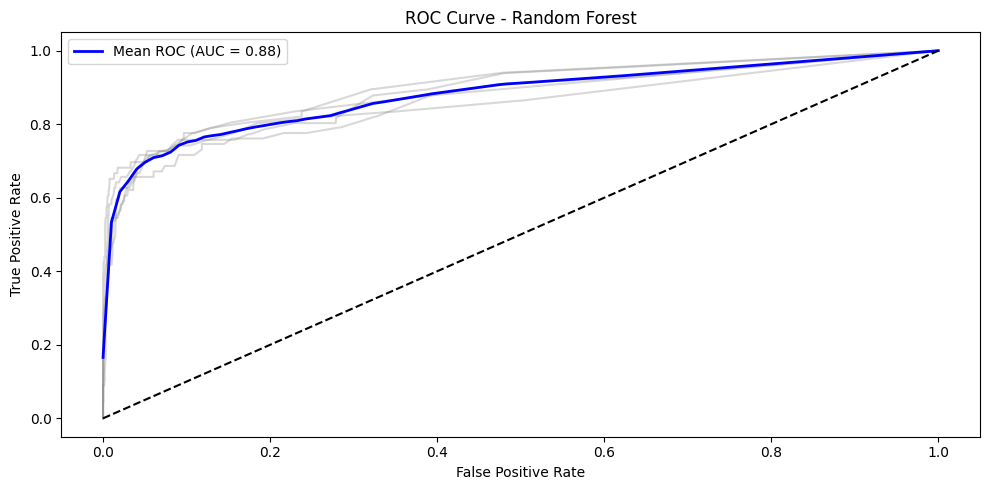

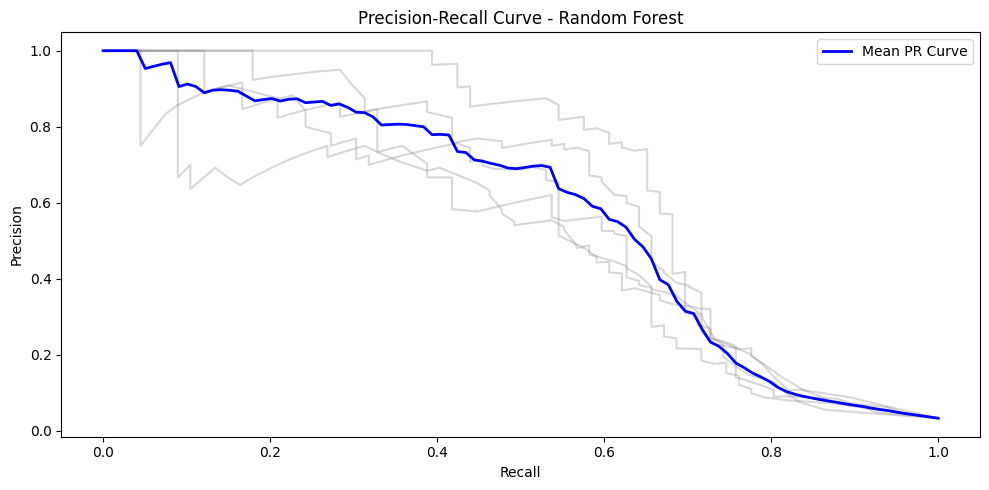

In [20]:
from sklearn.metrics import auc

# ROC Curve
plt.figure(figsize=(10, 5))
for fpr, tpr in zip(rf_fprs, rf_tprs):
    plt.plot(fpr, tpr, color='gray', alpha=0.3)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(rf_fprs, rf_tprs)], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# PR Curve
plt.figure(figsize=(10, 5))
for precision, recall in zip(rf_precisions, rf_recalls):
    plt.plot(recall, precision, color='gray', alpha=0.3)

mean_recall = np.linspace(0, 1, 100)
mean_precision = np.mean([np.interp(mean_recall, recall[::-1], precision[::-1])
                          for precision, recall in zip(rf_precisions, rf_recalls)], axis=0)

plt.plot(mean_recall, mean_precision, color='blue', label='Mean PR Curve', lw=2)
plt.title('Precision-Recall Curve - Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
logo = LeaveOneGroupOut()
cpus = 8
scores_lan = []
label_list = []
labels = np.asarray(labels)
pbar = tqdm(total=len(set(groups_loci)))
for train_index, test_index in logo.split(features_esm2, labels, groups_loci):
    #print(test_index)
    # get the training and test data
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i==1]) / sum([1 for i in y_train if i==0])

    ## ESM-2 EMBEDDINGS: XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss')
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    
    # save labels for later
    label_list.append(y_test)
    
    # pbar update
    pbar.update(1)
pbar.close()